In [474]:
from trackml.dataset import load_event
from trackml.dataset import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

block_cols = ['volume_id', 'layer_id', 'module_id']

def proc_arr(x):
    for i in range(len(x) - 1):
        block_stat.ix[x[i], x[i+1]] += 1
        
def proc_arr_next_hit(x):
    for i in range(len(x) - 1):
        next_hits.ix[x[i], 'next_hit'] = x[i+1]

In [2]:
def get_cell_stats(cells):
    cell_stats = cells.groupby('hit_id')['value'].mean().reset_index().rename({'value':'value_mean'},axis=1)

    tmp = cells.groupby('hit_id')['value'].max().reset_index().rename({'value':'value_max'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].min().reset_index().rename({'value':'value_min'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].sum().reset_index().rename({'value':'value_sum'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].std().reset_index().rename({'value':'value_std'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].count().reset_index().rename({'value':'value_count'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')    
    
    cell_cols = list(cell_stats.columns.values[1:])
    return cell_stats

In [3]:
def get_next_particle(truth_hits):
    truth_hits['next_particle'] = list(truth_hits['particle_id'].values[1:]) + [-1]
    truth_hits['next_hit'] = list(truth_hits['hit_id'].values[1:]) + [-1]
    truth_hits['not_end_hit'] = truth_hits['particle_id'] == truth_hits['next_particle']
    truth_hits['next_hit']  = truth_hits['not_end_hit'] * truth_hits['next_hit']
    return truth_hits['next_hit']

In [4]:
def is_start_hit(truth_hits, particles):
    truth_hits = pd.merge(truth_hits, particles, on='particle_id', how='left')
    truth_hits['to_start'] = (truth_hits['x'] - truth_hits['vx'])**2+(truth_hits['y'] - truth_hits['vy'])**2+(truth_hits['z'] - truth_hits['vz'])**2
    truth_hits = truth_hits.sort_values(['particle_id', 'to_start'])
    tmp = truth_hits.drop_duplicates('particle_id', keep='first')[['particle_id', 'to_start']]
    tmp['target'] = 1
    truth_hits = pd.merge(truth_hits, tmp, on=['particle_id', 'to_start'], how='left')   
    truth_hits.fillna(0, inplace=True)
    return truth_hits['target']

In [200]:
detectors = pd.read_csv('data/detectors.csv')
detectors['idx'] = range(len(detectors))
detectors
detectors.columns.values

array(['volume_id', 'layer_id', 'module_id', 'cx', 'cy', 'cz', 'rot_xu',
       'rot_xv', 'rot_xw', 'rot_yu', 'rot_yv', 'rot_yw', 'rot_zu',
       'rot_zv', 'rot_zw', 'module_t', 'module_minhu', 'module_maxhu',
       'module_hv', 'pitch_u', 'pitch_v'], dtype=object)

In [206]:
tmp.shape

(18728, 9)

In [290]:
A = detectors[['rot_xu',
       'rot_xv', 'rot_xw', 'rot_yu', 'rot_yv', 'rot_yw', 'rot_zu',
       'rot_zv', 'rot_zw']].values
A = A.reshape(18728, 3, 3)
A = np.linalg.inv(A)

c = detectors[['cx', 'cy', 'cz']].values

In [22]:
truth_hits.groupby(['volume_id', 'layer_id', 'module_id'])['hit_id'].count().reset_index()\
.groupby(['volume_id', 'layer_id'])['module_id'].count()

volume_id  layer_id
7          2            108
           4            108
           6            108
           8            108
           10           108
           12           108
           14           108
8          2            211
           4            448
           6            726
           8           1073
9          2            108
           4            108
           6            108
           8            108
           10           108
           12           108
           14           108
12         2            170
           4            170
           6            170
           8            169
           10           170
           12           170
13         2            833
           4           1147
           6           1550
           8           1825
14         2            170
           4            170
           6            170
           8            169
           10           170
           12           170
16         2             98


In [197]:
tmp = pd.merge(cells, truth_hits[['hit_id', 'volume_id', 'layer_id']], on='hit_id', how='left')
for i in [2,4,6,8,10,12]:
    tmp = pd.merge(cells, truth_hits[['hit_id', 'volume_id', 'layer_id']], on='hit_id', how='left')
    tmp = tmp[(tmp.volume_id == 7) & (tmp.layer_id == i)]
    print(tmp['ch0'].max(), tmp['ch1'].max())

335 1275
335 1278
335 1277
335 1279
335 1278
335 1279


In [143]:
zero_pixels = pd.DataFrame()
zero_pixels['hit_id'] = np.ones(1280) * -1
zero_pixels['ch0'] = list(range(336)) + [0] * (1280 - 336)
zero_pixels['ch1'] = range(1280)
zero_pixels['value'] = 0
zero_pixels['value'] = np.nan

In [471]:
%%time
np.random.seed(1)

cnt = 0
X_train = pd.DataFrame()
X_val = pd.DataFrame()

for event_id, hits, cells, particles, truth in load_dataset('data/train_5.zip'):

    truth_hits = pd.concat([hits, truth.drop(['hit_id'], axis=1)], axis=1)

    tmp = pd.merge(cells, hits[['hit_id'] + block_cols], on='hit_id', how='left')
    #tmp = tmp[(tmp.volume_id == 7) & (tmp.layer_id == 12) & (tmp.module_id == 3)]
    tmp = tmp[(tmp.volume_id == 9) & (tmp.layer_id == 14)]
    
    X = pd.concat([X, tmp], axis=0)[['hit_id', 'ch0', 'ch1', 'value'] + block_cols]
    X = pd.merge(X, truth[['hit_id', 'tx', 'ty', 'tz','tpx', 'tpy', 'tpz']], on='hit_id', how='left')

    X = pd.merge(X, detectors[block_cols + ['idx']], on=block_cols, how='left')
    
    X_train = pd.concat([X_train, X], axis=0)
    if cnt == 100:
        break
    cnt += 1

CPU times: user 2min 10s, sys: 30.9 s, total: 2min 41s
Wall time: 2min 41s


In [465]:
X_train.shape

(28994995, 14)

(array([309319., 146145., 113090., ...,   3957.,   3976.,   6002.]),
 array([-1000000. ,  -966751.9,  -933503.8, ...,   928389.8,   961637.9,
          994886. ]),
 <a list of 60 Patch objects>)

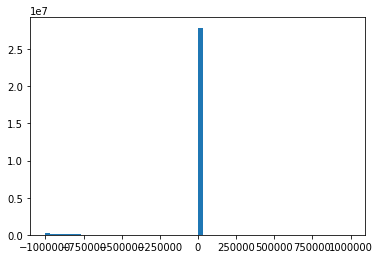

In [466]:
plt.hist(X_train['tpz'], bins=60)

In [382]:
tr = X[['tx', 'ty', 'tz']].values

In [339]:
def translate(x, y, z, idx):
    return list(np.dot(A[int(idx)], [x, y, z]) - c[int(idx)])

In [ ]:
r = np.array(X.apply(lambda x: translate(*x[-7:-4], x[-1]),axis=1))
r = np.hstack(r).reshape(len(r), 3)

p = np.array(X.apply(lambda x: translate(*x[-4:]),axis=1))
p = np.hstack(p).reshape(len(p), 3)

p_ = p - r

In [468]:
r

array([[ 122.227,  -88.897, 1400.   ],
       [ 122.227,  -88.897, 1400.   ],
       [ 124.157, -139.189, 1400.   ],
       ...,
       [ 132.526,  127.48 , 1196.   ],
       [ 146.473,   97.93 , 1196.   ],
       [ 146.473,   97.93 , 1196.   ]])

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[:,0], r[:, 1], r[:, 2])
#ax.scatter(t[:,0], t[:, 1], t[:, 2])


In [462]:
t = r+p/10000

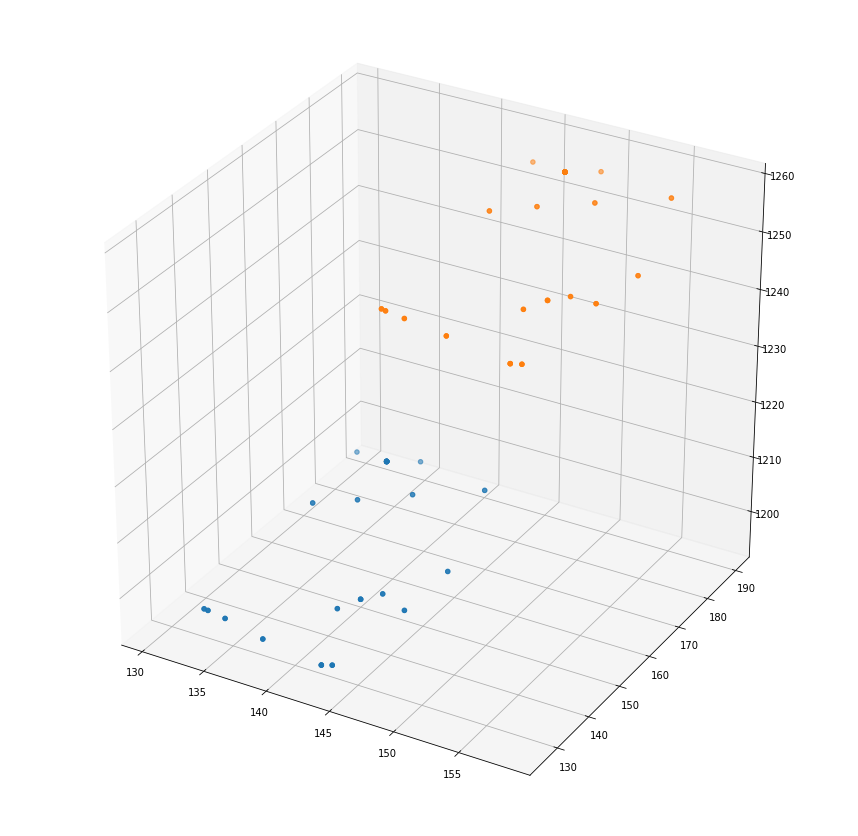

In [427]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r[:,0], r[:, 1], r[:, 2])
ax.scatter(t[:,0], t[:, 1], t[:, 2])


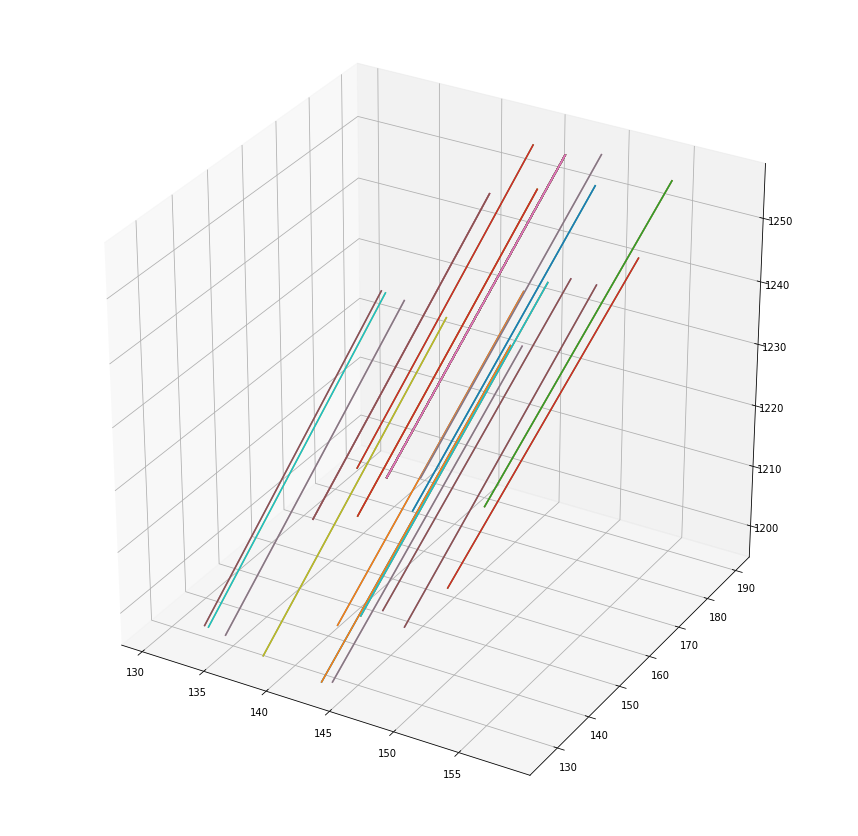

In [428]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(p)):
    ax.plot([r[i][0], t[i][0]], [r[i][1], t[i][1]], [r[i][2], t[i][2]])

In [362]:
np.set_printoptions(precision=3, threshold=5)
(p - r).astype('float32')

array([[   1.91 , -128.651, -598.012],
       [   1.91 , -128.651, -598.012],
       [  -7.166, -167.062, -600.079],
       ...,
       [  -4.427, -111.684, -598.489],
       [   5.507, -116.387, -596.553],
       [   5.507, -116.387, -596.553]], dtype=float32)

In [429]:
X = pd.concat([zero_pixels, X], axis=0)

In [420]:
tmp.shape

(1280, 336)

In [446]:
X

,hit_id,ch0,ch1,value,volume_id,layer_id,module_id,tx,ty,tz,tpx,tpy,tpz,idx
0,13115,216,482,0.241818,7,12,3,-129.544006,-20.504900,-698.0,173706.000000,22.017700,-984797.000000,542
1,13115,216,481,0.020783,7,12,3,-129.544006,-20.504900,-698.0,173706.000000,22.017700,-984797.000000,542
2,13116,146,86,0.103535,7,12,3,-107.931000,-13.974000,-698.0,-0.615374,-0.117339,-4.014870,542
3,13116,146,85,0.217932,7,12,3,-107.931000,-13.974000,-698.0,-0.615374,-0.117339,-4.014870,542
4,13117,314,835,0.047922,7,12,3,-148.587997,-28.110399,-698.0,-0.286544,-0.101861,-1.394180,542
5,13117,314,836,0.244939,7,12,3,-148.587997,-28.110399,-698.0,-0.286544,-0.101861,-1.394180,542
6,13118,189,237,0.328808,7,12,3,-116.093002,-17.272600,-698.0,-0.365091,-0.087918,-2.240460,542
7,13118,189,238,0.025006,7,12,3,-116.093002,-17.272600,-698.0,-0.365091,-0.087918,-2.240460,542
8,13119,148,1210,0.039700,7,12,3,-170.617004,-22.796801,-698.0,-0.145232,-0.068567,-0.651094,542
9,13119,148,1211,0.220196,7,12,3,-170.617004,-22.796801,-698.0,-0.145232,-0.068567,-0.651094,542


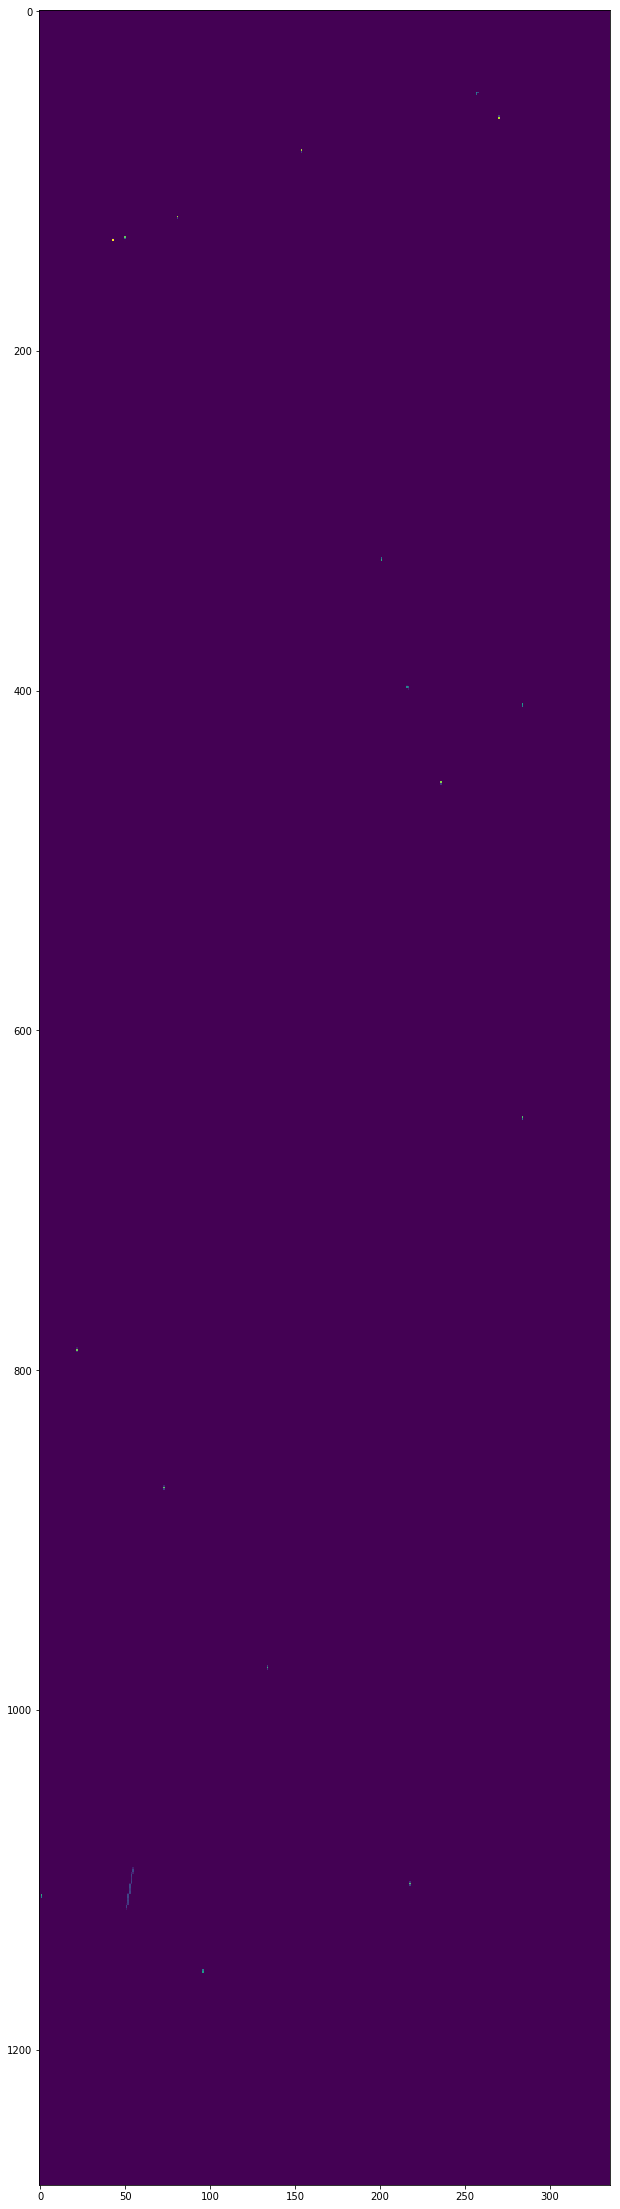

In [431]:
tmp = X.groupby(['ch0', 'ch1'])['value'].sum().reset_index().pivot(index='ch0', columns='ch1', values='value').fillna(0).values.T

plt.figure(figsize=(45,40))
#plt.imshow(tmp[ 0:300, 250:500])
plt.imshow(tmp)

In [13]:
%%time
np.random.seed(1)

cnt = 0
X_train = pd.DataFrame()
X_val = pd.DataFrame()

for event_id, hits, cells, particles, truth in load_dataset('data/train_5.zip'):

    
    
    truth_hits = pd.concat([hits, truth.drop(['hit_id'], axis=1)], axis=1)
    truth_hits['dist'] = truth_hits.apply(lambda x: x[1]**2 + x[2]**2 + x[3]**2, axis=1)
    truth_hits['rad_dist'] = truth_hits.apply(lambda x: x[1]**2 + x[2]**2, axis=1)
    
    truth_hits = truth_hits[truth_hits.particle_id != 0].sort_values(['particle_id', 'rad_dist'])
        
    if cnt == 0:
        break
        
    cell_stats = get_cell_stats(cells)
    cell_cols = list(cell_stats.columns.values[1:])
    truth_hits = pd.merge(truth_hits, cell_stats, on='hit_id', how='left')
    
    geom_cols = ['x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'dist', 'rad_dist']
    
    truth_hits['next_hit'] = get_next_particle(truth_hits)
    truth_hits['is_start_hit'] = is_start_hit(truth_hits, particles)
    
    
    # Составление тру пар
    X = truth_hits[truth_hits.is_start_hit == 1][['hit_id'] + geom_cols + cell_cols + ['next_hit']].rename({'hit_id':'hit_id_x'},axis=1)
    tmp = truth_hits[['hit_id'] + geom_cols + cell_cols]
    X = pd.merge(X.rename({'next_hit':'hit_id'},axis=1), tmp, on=['hit_id'], how='left').rename({'hit_id':'hit_id_y'},axis=1)
    first_cols = [ x + '_x' for x in  geom_cols + cell_cols ]
    second_cols = [ x + '_y' for x in  geom_cols + cell_cols ]



    # Составление не тру пар
    tmp = X[ ['hit_id_x'] + first_cols ]
    idxs = list(tmp.index.values) * 1000
    tmp = tmp.ix[idxs]
    tmp.index = range(len(tmp))

    tmp1 = truth_hits[['hit_id'] + geom_cols + cell_cols]
    tmp1.columns = ['hit_id_y'] + second_cols
    np.random.seed(1)
    idxs = np.random.choice(tmp1.index.values, tmp.shape[0])
    tmp1 = tmp1.ix[idxs]    
    tmp1.index = range(len(tmp1))

    tmp = pd.concat([tmp, tmp1], axis=1)
    tmp = tmp[X.columns]


    

    X['target'] = 1
    tmp['target'] = 0
    X = pd.concat([X, tmp], axis=0)
    X.index=range(len(X))

    
    X['f1'] = (X['x_x'] - X['x_y'])**2 + (X['y_x'] - X['y_y'])**2 + (X['z_x'] - X['z_y'])**2    
    X['f2'] = (X['z_x'] - X['z_y']) / (X['x_x'] - X['x_y'])
    X['f3'] = (X['z_x'] - X['z_y']) / (X['y_x'] - X['y_y'])
    
    if cnt == 0 or cnt == 1:
        X_val = pd.concat([X_val, X], axis=0)
    else:
        X_train = pd.concat([X_train, X], axis=0)
    
    print(cnt)

#     if cnt == 0:
#         break
        
    cnt += 1

CPU times: user 6.98 s, sys: 36 ms, total: 7.02 s
Wall time: 7.02 s


In [52]:
X_train['target'].mean()

0.000999000999000999

In [56]:
import gc
gc.collect()

0

In [11]:
1 - X_val['target'].mean(),  X_val['target'].mean()

(0.999000999000999, 0.000999000999000999)

In [18]:
X_train.shape

(26356330, 34)

In [58]:
X_val.shape

(20327307, 34)

In [6]:
%%time
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

scores = []

cat = ['module_id', 'volume_id', 'layer_id']

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['target'] ,axis=1), X_train['target'])

pred = lgb.predict(X_val.drop(['target'],axis=1))#[:,1]
print(accuracy_score( X_val['target'], pred))

pred = lgb.predict_proba(X_val.drop(['target'],axis=1))[:,1]
print(roc_auc_score( X_val['target'], pred))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9994319955909555
0.9917893512599034


In [9]:
pred = lgb.predict(X_val.drop(['target'],axis=1))#[:,1]
pred.mean()

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.0007089478207811787

In [15]:
(pred == 1).sum()

14411

In [17]:
recall_score(X_val['target'], pred)

0.5705421775742355

In [ ]:
0.9993020332165913
0.9976693708564695

In [ ]:
0.9974847311877941 6.324812597346277e-05
0.994532583391577 0.00014189783980856174

In [345]:
X

,hit_id_x,x_x,y_x,z_x,volume_id_x,layer_id_x,module_id_x,dist_x,rad_dist_x,value_mean_x,...,value_mean_y,value_max_y,value_min_y,value_sum_y,value_std_y,value_count_y,target,f1,f2,f3
0,24512.0,-23.265100,21.374300,24.842300,8.0,2.0,126.0,1.615265e+03,9.981256e+02,0.075452,...,0.049316,0.098625,0.005015,0.394525,0.037147,8.0,1,2.377697e+00,-0.967303,1.004787
1,24679.0,-24.176500,22.251699,25.723900,8.0,2.0,127.0,1.741360e+03,1.079641e+03,0.049316,...,0.064648,0.116255,0.004476,0.387891,0.047012,6.0,1,2.184191e+03,-1.012451,0.972338
2,31853.0,-50.680801,49.849400,52.558201,8.0,4.0,252.0,7.815871e+03,5.053506e+03,0.064648,...,0.053543,0.091496,0.002489,0.374802,0.030808,7.0,1,5.446158e+00,-1.048147,0.945630
3,31906.0,-51.960201,51.267502,53.899200,8.0,4.0,253.0,8.233343e+03,5.328219e+03,0.053543,...,0.055144,0.089593,0.014848,0.386005,0.030751,7.0,1,2.891217e+03,-1.101304,0.922153
4,39335.0,-80.146599,84.929802,84.941002,8.0,6.0,462.0,2.085152e+04,1.363655e+04,0.055144,...,0.058111,0.104747,0.019814,0.406778,0.029680,7.0,1,4.745783e+03,-1.219926,0.878327
5,45419.0,-112.924004,130.455002,124.927002,8.0,8.0,692.0,4.537709e+04,2.977034e+04,0.058111,...,1.000000,1.000000,1.000000,3.000000,0.000000,3.0,1,1.168721e+04,-1.448515,0.811664
6,76751.0,-156.052994,207.423996,187.399994,13.0,2.0,515.0,1.024960e+05,6.737725e+04,1.000000,...,1.000000,1.000000,1.000000,3.000000,0.000000,3.0,1,1.505353e+04,-2.007493,0.773382
7,83821.0,-191.819000,300.263000,259.200012,13.0,4.0,776.0,1.941370e+05,1.269524e+05,1.000000,...,1.000000,1.000000,1.000000,2.000000,0.000000,2.0,1,6.246042e+01,-2.637345,0.798799
8,83813.0,-193.639008,306.272003,264.000000,13.0,4.0,775.0,2.009946e+05,1.312986e+05,1.000000,...,1.000000,1.000000,1.000000,3.000000,0.000000,3.0,1,3.214620e+04,-4.308900,0.737249
9,90457.0,-218.100006,449.235992,369.399994,13.0,6.0,1157.0,3.858369e+05,2.493806e+05,1.000000,...,1.000000,1.000000,1.000000,4.000000,0.000000,4.0,1,6.241001e+01,-13.120028,0.694015


In [343]:
imp = pd.DataFrame()
imp['feature'] = X.drop(['target'], axis=1).columns.values
imp['importance'] = lgb.feature_importances_
imp = imp.sort_values('importance', ascending=False)
imp.index = range(len(imp))

In [344]:
imp

,feature,importance
0,f1,839
1,rad_dist_y,485
2,dist_y,261
3,rad_dist_x,251
4,dist_x,246
5,value_sum_x,211
6,value_sum_y,106
7,value_count_y,95
8,value_count_x,74
9,f3,68


In [204]:
1-X['target'].mean()

0.5

In [149]:
X

,x_x,y_x,z_x,volume_id_x,layer_id_x,module_id_x,dist_x,rad_dist_x,x_y,y_y,z_y,volume_id_y,layer_id_y,module_id_y,dist_y,rad_dist_y,target,fold,f1
0,-38.421902,60.531502,100.994003,8,4,283,1.534009e+04,5.140305e+03,-61.762501,97.524200,165.076996,8.0,6.0,512.0,4.057599e+04,1.332558e+04,1,1.0,6019.873047
1,-61.762501,97.524200,165.076996,8,6,512,4.057599e+04,1.332558e+04,-91.977898,145.654999,248.330994,8.0,8.0,846.0,9.134359e+04,2.967531e+04,1,2.0,10160.771484
2,-91.977898,145.654999,248.330994,8,8,846,9.134359e+04,2.967531e+04,-139.442993,221.778000,379.600006,13.0,2.0,594.0,2.127260e+05,6.862983e+04,1,0.0,25279.199219
3,-139.442993,221.778000,379.600006,13,2,594,2.127260e+05,6.862983e+04,-188.819000,301.776001,517.400024,13.0,4.0,888.0,3.944242e+05,1.267214e+05,1,4.0,27826.515625
4,-188.819000,301.776001,517.400024,13,4,888,3.944242e+05,1.267214e+05,-191.951004,306.898010,526.400024,13.0,4.0,887.0,4.081286e+05,1.310316e+05,1,0.0,117.044426
5,-191.951004,306.898010,526.400024,13,4,887,4.081286e+05,1.310316e+05,-262.704987,422.963989,725.799988,13.0,6.0,1392.0,7.746981e+05,2.479124e+05,1,2.0,58237.781250
6,-262.704987,422.963989,725.799988,13,6,1392,7.746981e+05,2.479124e+05,-345.194000,560.494019,960.599976,13.0,8.0,2024.0,1.356065e+06,4.333124e+05,1,1.0,80849.984375
7,-345.194000,560.494019,960.599976,13,8,2024,1.356065e+06,4.333124e+05,-431.626007,707.424011,1217.500000,18.0,2.0,83.0,2.169056e+06,6.867497e+05,1,2.0,95056.539062
8,-431.626007,707.424011,1217.500000,18,2,83,2.169056e+06,6.867497e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,NaN
9,-23.600700,21.074499,28.903299,8,2,126,1.836528e+03,1.001128e+03,-24.391100,21.806400,30.028799,8.0,2.0,127.0,1.972174e+03,1.070445e+03,1,0.0,2.427160
